# Setup Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Case Study on Autoregression

## Reading the Data

Let's look at a dataset that describes the minimum daily temperatures over 10 years (1981-1990) in the city of Melbourne, Australia.

The units are in degrees Celsius and there are 3,650 observations. The source of the data is the Australian Bureau of Meteorology.

Note: This dataset ignores a day in leap years for consistent number of observations (365) in each year.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df  = pd.read_csv("/content/drive/MyDrive/UMD - senior year/spring 2022/439D/Lab 3/daily-min-temp-melb.csv", index_col=0, parse_dates=True) 

# fill in missing values
idx = pd.date_range('1981-01-01', '1990-12-31')
df = df.reindex(idx)
df.fillna(method='backfill',inplace=True)

df.tail()

Mounted at /content/drive


,min_temp
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [3]:
len(df)

3652

## Visualizing Data

Let's visualize what the minimum daily temperature data looks like. Alongside with it, we also plot the rolling mean to smooth out variations in each 365-day window. <br>

**NOTE:** The rolling mean appears to start high and then stabilize after about 365 days because in the first year, it just averages the observations it does have in that window ($\leq$365). This makes the rolling mean higher for that period since the temperates are higher early on.

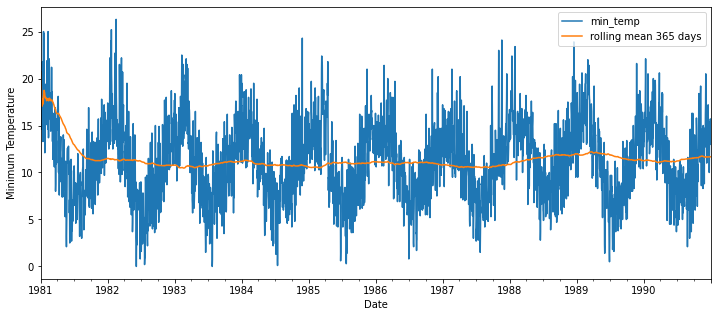

In [4]:
# Plotting the original data and the 365 day rolling mean
ax = df.plot(figsize=(12,5));

df.min_temp.rolling("365d").mean().plot(ax=ax, label='rolling mean 365 days')
# df.min_temp.rolling("7d").mean().plot(ax=ax, label='rolling mean 365 days')
ax.set_ylabel("Minimum Temperature")
ax.set_xlabel("Date")
ax.legend();

Autoregression relies on the relationship between a value at a particular time step (say, t), and the values at earlier time steps (t-1, t-2, and so on) or **lags**. Using a lag plot, we can visualize how the previous time step relates with the current one.

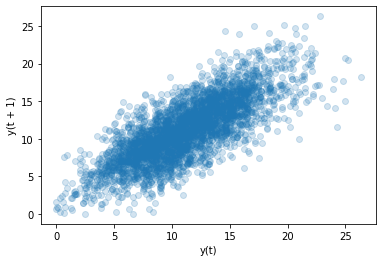

In [5]:
from pandas.plotting import lag_plot

# Visualizing the lag plot.
# By default lag=1
lag_plot(df.min_temp, alpha=0.2);

We can visualize lag plot at higher lags as well!

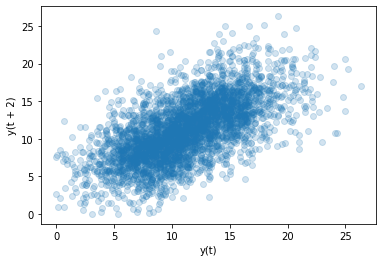

In [6]:
lag_plot(df.min_temp, lag=2, alpha=0.2);

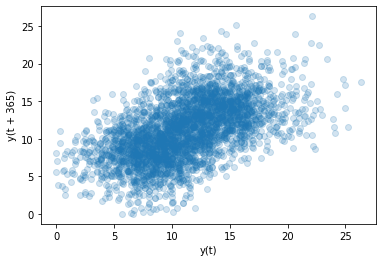

In [7]:
lag_plot(df.min_temp, lag=365, alpha=0.2);

We see that while the lag plot at lag=1 does indicate a somewhat linear relationship between minimum temperature values at time steps t, and t-1 (or alternatively at t+1 and t, whichever way you want to look at it!). However, this relation becomes weaker as lags increase.

## Autoregression Model

We will now use a simple Autoregression model for the task of forecasting ahead.
We have minimum-temperature data for 10 years, so let's say we want to predict the last 7 days of this 10-year period using the other observations before it (3650-7 = 3643)

In [8]:
# Defining the train set, all days but the last 7: 1981-01-01 to 1990-12-24
dftrain = df.loc[:'1990-12-24']
dftrain.tail()

,min_temp
1990-12-20,15.4
1990-12-21,13.1
1990-12-22,13.2
1990-12-23,13.9
1990-12-24,10.0


In [9]:
# The test set: The last 7 days: 1990-12-25 to 1990-12-31
dftest = df.loc['1990-12-25':]
dftest

,min_temp
1990-12-25,12.9
1990-12-26,14.6
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


**Note:** The `statsmodels` library has autoregression models, but the syntax is slightly different from that of `sklearn` .<br>
* While defining the model object, we pass in the time-series we want to forecast (Instead of during fitting)
* The `.fit()` function takes in the `maxlag` argument (Instead of the doing this during object declaration)

In [10]:
from statsmodels.tsa.ar_model import AR
from datetime import datetime

model = AR(dftrain.min_temp)
model_fit = model.fit(maxlag=1)

print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

yhat = model_fit.predict(start='1990-12-25', end='1990-12-31')

Lag: 1
Coefficients: const          2.518687
L1.min_temp    0.774337
dtype: float64


### Visualizing our predictions

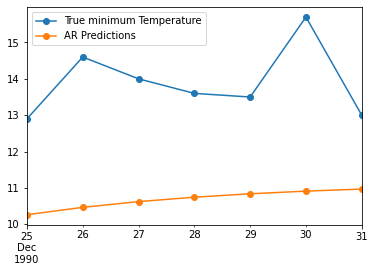

In [11]:
# add predictions to the test dataframe
dftest["predictions"] = yhat

ax = dftest.min_temp.plot(marker='o', label="True minimum Temperature")
dftest.predictions.plot(ax=ax, marker='o', label='AR Predictions');
ax.legend();

We can now check if our predictions improve if we consider more time lags of observations for Autoregression. (Check by setting maxlag=2, 3, 365 etc.)

# In-Class Quiz

### Question 1
> In this question, you task is to fit an AR model using the same dataset and training data as before (1981-01-01 to 1990-12-24). Then, you have to forecast for the period of same testing data (1990-12-25 to 1990-12-31) choosing a value of `maxlag` that corresponds to using a maximum of `5` past observations. **Find the "Mean squared error" between the predicted values and the true minimum temperature values for the testing period.**. Report your answer rounded to 2 decimal places.
>
> **Hint:** See the starter code below!

In [12]:
# Given code
from sklearn.metrics import mean_squared_error

# dftrain and dftest are the same as the code above
dftrain2 = df.loc[:'1990-12-24']
dftest2 = df.loc['1990-12-25':]

In [13]:
# Your code here (retrain using maxlag=5 and then use mean_squared_error)
model2 = AR(dftrain2.min_temp)
model_fit2 = model2.fit(maxlag=5)

print('Lag: %s' % model_fit2.k_ar)
print('Coefficients: %s' % model_fit2.params)

yhat = model_fit2.predict(start='1990-12-25', end='1990-12-31')

Lag: 5
Coefficients: const          1.393423
L1.min_temp    0.652201
L2.min_temp   -0.062285
L3.min_temp    0.091106
L4.min_temp    0.064174
L5.min_temp    0.129795
dtype: float64


new model mse:  6.09


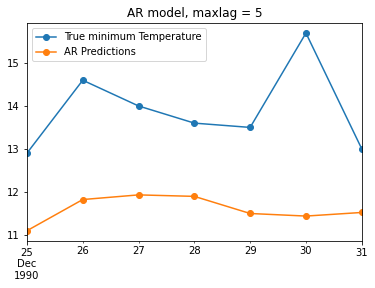

In [14]:
# add predictions to the test dataframe
dftest2["predictions"] = yhat

ax = dftest2.min_temp.plot(marker='o', label="True minimum Temperature", title='AR model, maxlag = 5')
dftest2.predictions.plot(ax=ax, marker='o', label='AR Predictions');
ax.legend();

model2_mse = round(mean_squared_error(dftest2.min_temp, dftest2.predictions),2)
print('new model mse: ', model2_mse)

### Question 2
> In the case study, we forecasted minimum temperature values for 7 days (1990-12-25 to 1990-12-31) ahead from the last date in the training period (1981-01-01 to 1990-12-24). Suppose you want to get predictions on the **5th of January 1991** using a `maxlag=365` and the whole dataset. What value of minimum temperature is predicted using this AR model? Report your answer rounded to 2 decimal places.
>
> **Hint:** The "start" and "end" parameters in the .predict() method might be useful. The "start" parameter should be the end of the training set.

In [15]:
# Use all the data for training
dftrain = df

In [16]:
# Your code here (retrain using maxlag=365 and then predict Jan 5, 1991 by selecting "start" and "end")
model3 = AR(dftrain.min_temp)
model3_fit = model3.fit(maxlag=365)

print('Lag: %s' % model_fit2.k_ar)
print('Coefficients: %s' % model_fit2.params)

model3_predictions = model3_fit.predict(start='1991-1-1', end='1991-1-5')

Lag: 5
Coefficients: const          1.393423
L1.min_temp    0.652201
L2.min_temp   -0.062285
L3.min_temp    0.091106
L4.min_temp    0.064174
L5.min_temp    0.129795
dtype: float64


In [17]:
print('predicted temperature on 1991-1-5:', round(model3_predictions.loc['1991-1-5'], 2),)

predicted temperature on 1991-1-5: 14.42


# Sine Wave Modeling
>Implement Time series modelling using AR and RNN models for sine wave : Show a plot with your predictions v/s actual sine values at a point. Play with the model orders for AR models. 

## AR Sine Wave
>Creating an AR model to predict the future data points of a sine wave

Implement Time series modelling using AR and RNN models for sine wave : 

Show a plot with your predictions v/s actual sine values at a point. Play with the model orders for AR models.


In [ ]:
#import sine wave packages
!pip install UliEngineering;
from UliEngineering.SignalProcessing.Simulation import sine_wave, cosine_wave

import matplotlib.pyplot as plt

     |████████████████████████████████| 69 kB 3.3 MB/s 
  Created wheel for UliEngineering: filename=UliEngineering-0.3.7-py3-none-any.whl size=90964 sha256=f639a1709be31ac49cd89d68cb993be0d1c2fcc6e4fe3ef3ab9f7f301f5e9b02
  Stored in directory: /root/.cache/pip/wheels/69/41/89/127edb94c94a02817e4a27600b1ad5cb9c32374b4dc51af657
Successfully built UliEngineering


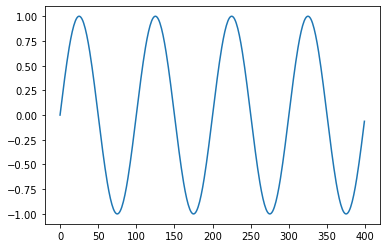

In [ ]:
# generate sine wave with parameters
# 10 Hz sine wave
# 10 kHz sampling
# Generate 1 second of data

my_sine_wave = sine_wave(frequency=10, samplerate=1000, length=.4)
plt.plot(my_sine_wave)

In [ ]:
#predict 1/4 of the dataset of my_sin_wave
len(my_sine_wave)

train_sine = my_sine_wave[:-100]
len(train_sine)

300

In [ ]:
#using AR model, predict samples of the sine wave, compare with actual results
sine_model = AR(train_sine)

sine_model_predict = sine_model.fit(maxlag=5)
print('Lag: %s' % sine_model_predict.k_ar)
print('Coefficients: %s' % sine_model_predict.params)

#predict values starting from end of training data
predictions = sine_model_predict.predict(start=len(train_sine), end = len(my_sine_wave) - 1)

Lag: 5
Coefficients: [-1.73472348e-17  7.94005420e-01  4.96990369e-01  1.98013924e-01
 -1.01743991e-01 -4.01100369e-01]


mse of prediction: 9.884285095892038e-28


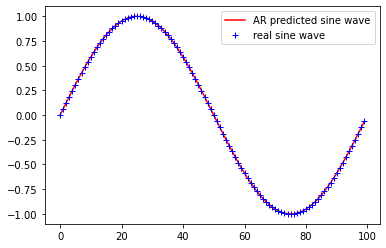

In [ ]:
#plot predictions vs real sine wave
real_sine_wave = my_sine_wave[-100:]

plt.plot(predictions, color='r', label='AR predicted sine wave')
plt.plot(real_sine_wave, 'b+', label='real sine wave')
plt.legend()

print("mse of prediction:", mean_squared_error(real_sine_wave, predictions))

As you can see, the predictions matched the actual sine wave extremely well, with a mse=9.884285095892038e-28 (virtually 0)

## RNN Sine Wave
>Creating an RNN model to predict the future data points of a sine wave

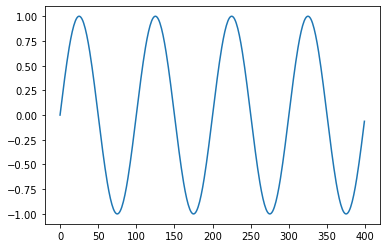

In [ ]:
plt.plot(my_sine_wave)

In [ ]:
#split up data into train and test
# train_sine = my_sine_wave[:-100]
# test_sine = my_sine_wave[-100:]

l = 5     #max_lag = l
n = 1     #prediction of next 1 sample = n

N = len(my_sine_wave)    # Total number of samples = N
k = N - (l + n)

# Create Input and output Slice
in_slice = np.array([range(i, i + l) for i in range(k)])
op_slice = np.array([range(i + l, i + l + n) for i in range(k)])

In [ ]:
#split the data into input and output slicing above
in_data = [my_sine_wave[in_slice[0]].tolist()]
for i in range(1,len(in_slice)):
  in_data = np.append(in_data, [my_sine_wave[in_slice[i]].tolist()], axis=0)

#split the data into input and output slicing above
out_data = [my_sine_wave[op_slice[0]].tolist()]
for i in range(1,len(op_slice)):
  out_data = np.append(out_data, [my_sine_wave[op_slice[i]].tolist()], axis=0)

in_data

array([[ 0.        ,  0.06279052,  0.12533323,  0.18738131,  0.24868989],
       [ 0.06279052,  0.12533323,  0.18738131,  0.24868989,  0.30901699],
       [ 0.12533323,  0.18738131,  0.24868989,  0.30901699,  0.36812455],
       ...,
       [-0.53582679, -0.48175367, -0.42577929, -0.36812455, -0.30901699],
       [-0.48175367, -0.42577929, -0.36812455, -0.30901699, -0.24868989],
       [-0.42577929, -0.36812455, -0.30901699, -0.24868989, -0.18738131]])

In [ ]:
len(out_data)

394

In [ ]:
xtrain,ytrain=in_data[:294],out_data[:294]
xtest,ytest=in_data[294:],out_data[294:]

In [ ]:
#import libraries and packages:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

#Initialize RNN:
regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences=True, input_shape= (xtrain.shape[1],1)))
regressor.add(Dropout(0.2))

#Adding the second RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the third RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

#Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
regressor.fit(xtrain, ytrain, epochs=100, batch_size=32)

In [ ]:
RNN_prediction = regressor.predict(xtest)
# predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

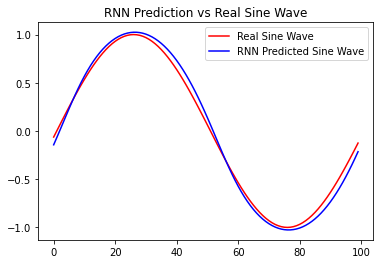

mse of RNN prediction: 0.0037171558680770887


In [ ]:
plt.plot(ytest, color='red', label='Real Sine Wave')
plt.plot(RNN_prediction, color='blue', label='RNN Predicted Sine Wave')
plt.title('RNN Prediction vs Real Sine Wave')
plt.legend()
plt.show()

print("mse of RNN prediction:", mean_squared_error(ytest, RNN_prediction))

Clearly the RNN did really well, though the data preperation for the RNN took very long and I dont know if the model did much better than the AR model

# Scaling and Shifting Sine Wave
>Scale and Shift the Sine wave. Report observations. Add noise to the sine waves. Constant noise and AWGN (Gaussian Noise) should be used. Change SNRs and report observations

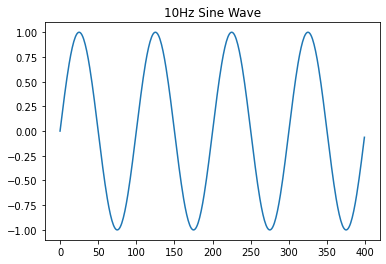

In [ ]:
#using the same sine wave generated in the previous part
plt.plot(my_sine_wave)
plt.title('10Hz Sine Wave');

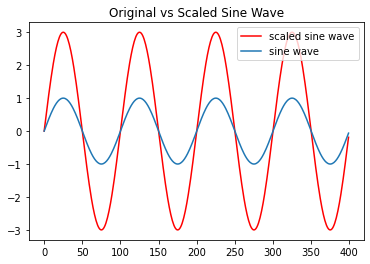

In [ ]:
#scale and shift sine wave
scaled_sine_wave = 3*my_sine_wave

plt.plot(scaled_sine_wave, 'r', label='scaled sine wave')
plt.plot(my_sine_wave, label='sine wave')
plt.title('Original vs Scaled Sine Wave');
plt.legend();

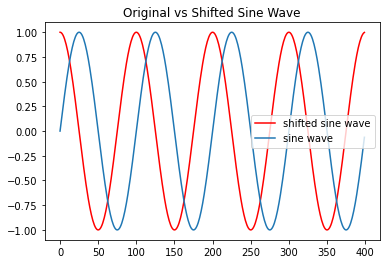

In [ ]:
#scale and shift sine wave
shifted = sine_wave(frequency=10.0, samplerate=1000, length=.4, phaseshift=90)

plt.plot(shifted, 'r', label='shifted sine wave')
plt.plot(my_sine_wave, label='sine wave')
plt.title('Original vs Shifted Sine Wave');
plt.legend();

I used this method - just creating a new shifted sine wave. However, I could have alternatively used the AR or RNN models to generate new samples at the tail of the original sine wave and then just remove a specific number of the earlier samples in order to phase shift the sine wave 

In [ ]:
len(my_sine_wave)

400

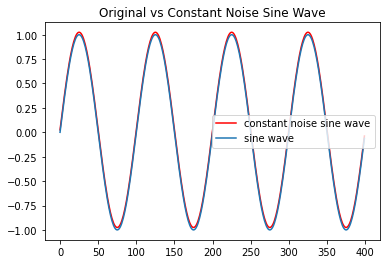

In [ ]:
#if constant noise means just adding one value (+.025) to sine wave
constant_noise_sine = my_sine_wave + .025

plt.plot(constant_noise_sine, 'r', label='constant noise sine wave')
plt.plot(my_sine_wave, label='sine wave')
plt.title('Original vs Constant Noise Sine Wave');
plt.legend();

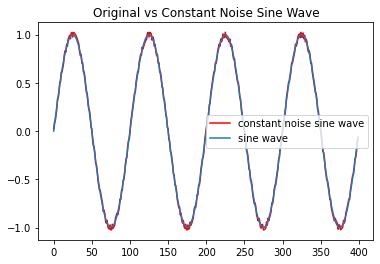

In [ ]:
#if constant noise means adding or subtracting constant (+ or - .025) to sine wave

#create list to use to create constant noise (+ or - .25)
import random
constant_noise_coeff = [-1.0,1.0]
randomlist = []
for i in range(0,400):
  n = random.choice(constant_noise_coeff)
  randomlist.append(n)


#add constant noise to sine wave
constant_noise_sine = my_sine_wave + .025*np.array(randomlist)

plt.plot(constant_noise_sine, 'r', label='constant noise sine wave')
plt.plot(my_sine_wave, label='sine wave')
plt.title('Original vs Constant Noise Sine Wave');
plt.legend();

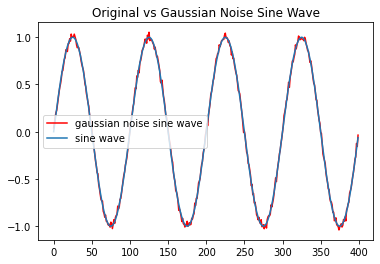

In [ ]:
#add constant noise to sine wave
gaussian_noise = np.random.normal(loc=0, scale=.025, size=len(my_sine_wave))

gaussian_noise_sine = my_sine_wave + gaussian_noise

plt.plot(gaussian_noise_sine, 'r', label='gaussian noise sine wave')
plt.plot(my_sine_wave, label='sine wave')
plt.title('Original vs Gaussian Noise Sine Wave');
plt.legend();

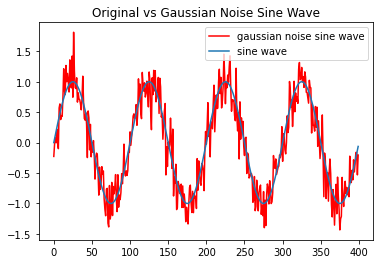

In [ ]:
#changing signal to noise ratio (through gaussian)
gaussian_noise2 = np.random.normal(loc=0, scale=.25, size=len(my_sine_wave))

gaussian_noise_sine2 = my_sine_wave + gaussian_noise2

plt.plot(gaussian_noise_sine2, 'r', label='gaussian noise sine wave')
plt.plot(my_sine_wave, label='sine wave')
plt.title('Original vs Gaussian Noise Sine Wave');
plt.legend();

### AR with noisy sine wave

mse of prediction: 0.1601707820639052


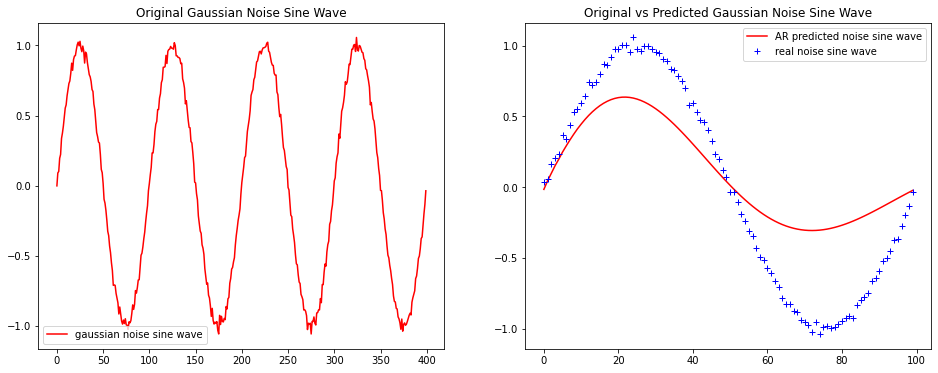

In [ ]:
#autoregression with noise signal

#split data into train and test
train_noise = gaussian_noise_sine[:-100]
test_noise = gaussian_noise_sine[-100:]

#using AR model, predict samples of the sine wave, compare with actual results
noise_model = AR(train_noise)
noise_mode_predict = noise_model.fit(maxlag=5)

# print('Lag: %s' % noise_mode_predict.k_ar)
# print('Coefficients: %s' % noise_mode_predict.params)
#predict values starting from end of training data
noise_predictions = noise_mode_predict.predict(start=len(train_noise), end = len(gaussian_noise) - 1)


#plot predictions vs real sine wave
figure, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(gaussian_noise_sine, 'r', label='gaussian noise sine wave')
ax1.set_title('Original Gaussian Noise Sine Wave');
ax1.legend();

ax2.plot(noise_predictions, color='r', label='AR predicted noise sine wave')
ax2.plot(test_noise, 'b+', label='real noise sine wave')
ax2.set_title('Original vs Predicted Gaussian Noise Sine Wave');
ax2.legend()

print("mse of prediction:", mean_squared_error(test_noise, noise_predictions))

This was ok, but not great. So I tried changing maxlag from 5 to 15

mse of prediction: 0.0005629322277371867


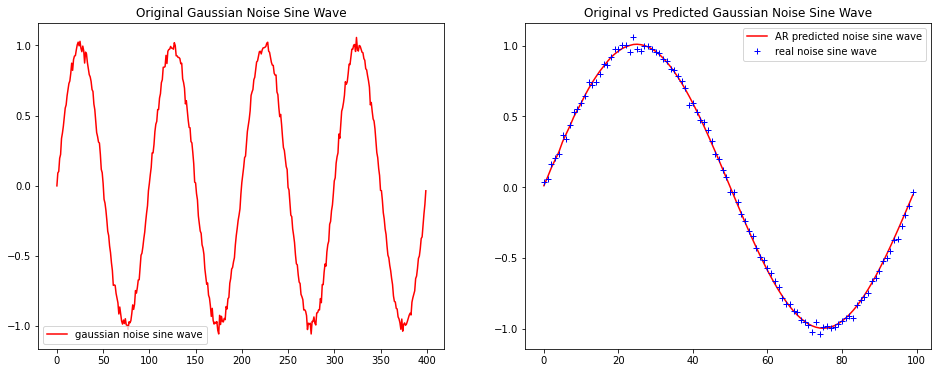

In [ ]:
#using AR model, predict samples of the sine wave, compare with actual results
noise_model = AR(train_noise)
noise_mode_predict = noise_model.fit(maxlag=15)

# print('Lag: %s' % noise_mode_predict.k_ar)
# print('Coefficients: %s' % noise_mode_predict.params)
#predict values starting from end of training data
noise_predictions = noise_mode_predict.predict(start=len(train_noise), end = len(gaussian_noise) - 1)


#plot predictions vs real sine wave
figure, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(gaussian_noise_sine, 'r', label='gaussian noise sine wave')
ax1.set_title('Original Gaussian Noise Sine Wave');
ax1.legend();

ax2.plot(noise_predictions, color='r', label='AR predicted noise sine wave')
ax2.plot(test_noise, 'b+', label='real noise sine wave')
ax2.set_title('Original vs Predicted Gaussian Noise Sine Wave');
ax2.legend()

print("mse of prediction:", mean_squared_error(test_noise, noise_predictions))

I then tried to do the same thing for the reall noisy model

mse of prediction: 0.08469558521021293


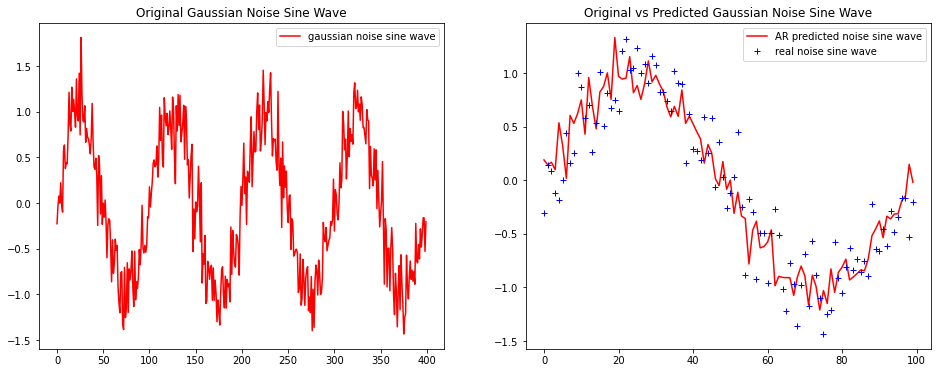

In [ ]:
#autoregression with noise signal 2

#split data into train and test
train_noise = gaussian_noise_sine2[:-100]
test_noise = gaussian_noise_sine2[-100:]

#using AR model, predict samples of the sine wave, compare with actual results
noise_model = AR(train_noise)
noise_mode_predict = noise_model.fit(maxlag=100)

# print('Lag: %s' % noise_mode_predict.k_ar)
# print('Coefficients: %s' % noise_mode_predict.params)
#predict values starting from end of training data
noise_predictions = noise_mode_predict.predict(start=len(train_noise), end = len(gaussian_noise) - 1)


#plot predictions vs real sine wave
figure, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(gaussian_noise_sine2, 'r', label='gaussian noise sine wave')
ax1.set_title('Original Gaussian Noise Sine Wave');
ax1.legend();

ax2.plot(noise_predictions, color='r', label='AR predicted noise sine wave')
ax2.plot(test_noise, 'b+', label='real noise sine wave')
ax2.set_title('Original vs Predicted Gaussian Noise Sine Wave');
ax2.legend()

print("mse of prediction:", mean_squared_error(test_noise, noise_predictions))

The above is an example of overfitting. The graphs below are a better representation of a good model that isnt overfit or underfit (I changed the maxlag from 100 to 40)

mse of prediction: 0.06620362781345936


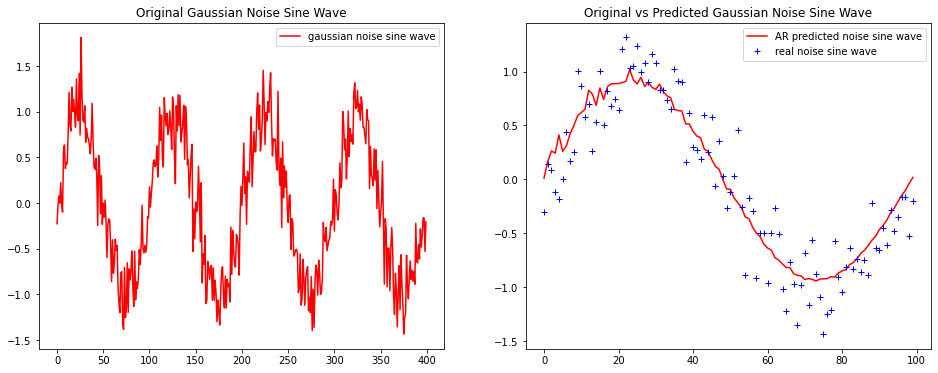

In [ ]:
#autoregression with noise signal 2

#split data into train and test
train_noise = gaussian_noise_sine2[:-100]
test_noise = gaussian_noise_sine2[-100:]

#using AR model, predict samples of the sine wave, compare with actual results
noise_model = AR(train_noise)
noise_mode_predict = noise_model.fit(maxlag=40)

# print('Lag: %s' % noise_mode_predict.k_ar)
# print('Coefficients: %s' % noise_mode_predict.params)
#predict values starting from end of training data
noise_predictions = noise_mode_predict.predict(start=len(train_noise), end = len(gaussian_noise) - 1)


#plot predictions vs real sine wave
figure, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(gaussian_noise_sine2, 'r', label='gaussian noise sine wave')
ax1.set_title('Original Gaussian Noise Sine Wave');
ax1.legend();

ax2.plot(noise_predictions, color='r', label='AR predicted noise sine wave')
ax2.plot(test_noise, 'b+', label='real noise sine wave')
ax2.set_title('Original vs Predicted Gaussian Noise Sine Wave');
ax2.legend()

print("mse of prediction:", mean_squared_error(test_noise, noise_predictions))

# Writeup
>Writeup explaining what you did and what you inferred from the blocks of code you wrote.

1. For Melbourne Temperature Dataset: 
> - For question 1, I made maxlag = 5 so that the model checked used the 5 previous datapoints in order to make its prediction. The previous model only checked the datapoint immediately before it and din't perform well, this new model performed better. 
> 
> 
> - For question 2, I used the model to predict the temperature for timestamps that were included in the dataset (5 days later) using the AR model and training data from 5 days before that **was** included

2. For the Sine Wave modeling: 
> - For part 1, I generated a sine wave, removed the last 100 samples and saved them as test samples, predicted these samples using a AR model with maxlag=5, and then plotted the predicted values against the test values and showed the mean square error. My results were really good.
> 
> - For part 2, I had to do a lot of dataprep to prepare the data for the RNN model. I made the input data into a 2D array with 5 samples in each array element, and the next array value held the next 5 t+1 samples of the sine wave data. The output data had only one value in each array element, the 6th value following the 5 value in the input data.
>> - input data = [[t,...,t+5], [t+1,...,t+6], ...]
>> - output data = [[t+6], [t+7], ...]
> - Then I removed the last 100 samples and saved them as test samples, inputed this data into a multilayer RNN and trained the RNN, and finally had the model predict the future values and plotted those values against the test data. The results were great




3. In the final question I generated a sine wave, scaled it by 3, shifted it by 90, and used added noise to the data using constant (+.025), random constant (+ or - .025), and gaussian noise (scaled at .025). Then I increased the noise of the sine wave, and trained both the smaller and very noise sine waves on AR models, and predicted the final 100 samples of the sine waves for each, and saw what the best model parameters were for each by plotting them against the test data and seeing their mean square error